# My Recommendation mini framework

## Data loading and exploration

We will work with Movie Lens 100k dataset. The dataset is available online.

In [145]:
import numpy as np
import pandas as pd
import sklearn
from scipy.stats import gaussian_kde

movies = pd.read_csv('ml-100k/u.data', sep='\t')
movies = movies.rename(index=str, columns={"196": "user_id", "242": "item_id", "3": "rating", "881250949": "timestamp"})

categories = pd.read_csv('ml-100k/u.item', sep='\t', encoding="iso-8859-1")

movies.info()

<class 'pandas.core.frame.DataFrame'>
Index: 99999 entries, 0 to 99998
Data columns (total 4 columns):
user_id      99999 non-null int64
item_id      99999 non-null int64
rating       99999 non-null int64
timestamp    99999 non-null int64
dtypes: int64(4)
memory usage: 3.8+ MB


# Explore the dataset
Now we want to have some insight about it. We can compute the following statistics:
* distribution of ratings per user
* distribution of ratings per movie
* mean / median / stddev / quantiles for all measures
* density

In [146]:
movies.describe()

user_id       item_id        rating     timestamp
count  99999.000000  99999.000000  99999.000000  9.999900e+04
mean     462.487415    425.531965      3.529865  8.835289e+08
std      266.614421    330.799501      1.125678  5.343878e+06
min        1.000000      1.000000      1.000000  8.747247e+08
25%      254.000000    175.000000      3.000000  8.794487e+08
50%      447.000000    322.000000      4.000000  8.828269e+08
75%      682.000000    631.000000      4.000000  8.882600e+08
max      943.000000   1682.000000      5.000000  8.932866e+08

## Statistics

The panda method "describe" is use to give us insight on the data. We have access to the quartiles, the mean, min, max, the number of elements and the standard deviation.

We can notice that these information are only relevant for the rating (and may be timestamp) column(s).

We are able to say that people are more likely to give good ratings (above the average: 3.0) and that the rating values converge through 4.

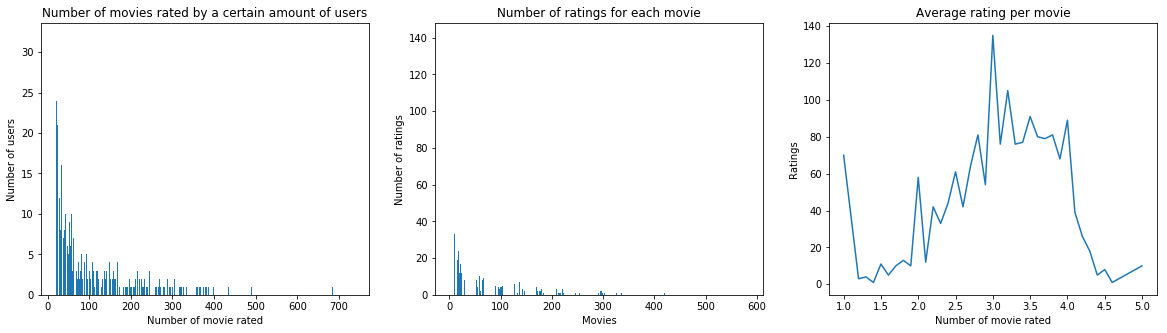

In [147]:
%matplotlib inline
from matplotlib import pyplot as plt

ratings_per_user = movies.groupby("user_id").count().loc[:, ["item_id"]].item_id
ratings_per_movie = movies.groupby("item_id").count().loc[:, ["user_id"]].user_id
movies_rate = movies.groupby("item_id").mean().round(1).loc[: , ["rating"]]
movies_rate["item_id"] = movies_rate.index
movies_rate = movies_rate.groupby("rating").count().item_id

plt.figure(figsize=(20, 5))

plt.subplot(1, 3, 1)

plt.hist(ratings_per_user, bins=ratings_per_user.shape[0])
plt.title("Number of movies rated by a certain amount of users")
plt.ylabel("Number of users")
plt.xlabel("Number of movie rated")


plt.subplot(1, 3, 2)

plt.hist(ratings_per_movie, bins=ratings_per_movie.shape[0])
plt.title("Number of ratings for each movie")
plt.ylabel("Number of ratings")
plt.xlabel("Movies")

plt.subplot(1, 3, 3)

plt.plot(movies_rate)
plt.title("Average rating per movie")
plt.ylabel("Number of movie rated")
plt.xlabel("Ratings")

plt.show()

## Distributions

These 3 plots show distributions for the different columns.

The first one gives us the number of users who rated a certain number X of movies. We can see that most of the users rated only between 20 and 60 movies which is not a lot since the minimum ratings a user needs to give to be in the dataset is 20.

The second plot helps us visualizing number of ratings that were given to a certain number X of movies. Few movies were rated between 10 and 40 times.

These plots tells us that the the pivot table (matrix) that links each user to each movie is quite sparse.

The last plot gives us the number of movies rated in average a certain rating X. Most of the movies were rated between 3 and 4. (The ratings are rounded with first decimal)

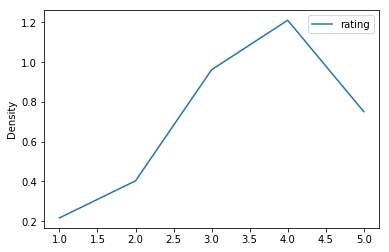

In [153]:
movies[["rating"]].plot.kde(ind=range(1, 6))
plt.show()

## Density

The cell above describes the density values for the ratings.

## Build your first algorithm

It is time to build a naive algorithm in order to test our recommendation framework. All the mentioned framework follow the same scikit-learn estimator convention.

## Estimator

Below you can find the Scikit-Learn estimator I implemented that extends "BaseEstimator".

The init method is just used to set the parameters and hyper-parameters used in the algorithm.

The fit method uses matrix factorization methods to fit data. I have also added a learning phase with a gradient descent optimizer and a root mean squared error cost function. I used the early stopping method when the algorithm stops converging, we stop iterate. The batch and the number of epochs are also important hyper-parameters that determine how the algorithm is going to learn.

The predict_set method had to be implemented to calculate easily results to test with metrics.

The predict method is implemented to respect the guidelines, you can give it an user_id and an item_id so it can predict the rating associated.

In [149]:
from sklearn.base import BaseEstimator
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.metrics import mean_squared_error
from math import sqrt
from numpy.random import RandomState


class MatrixFactorizationEstimator(BaseEstimator):

    # Estimator for matrix factorization
        
    def __init__(self, nb_users=0, nb_items=0, K=2, batch_size=1500, learning_rate=0.003,
                 seed=3, lambda_u=0.1,lambda_v=0.1, n_epochs=250):
                 
        self.nb_users = nb_users
        self.nb_items = nb_items
        self.random_state = RandomState(seed)

        # Hyper parameters
        self.K = K
        self.batch_size = batch_size
        self.n_epochs=n_epochs
        self.learning_rate = learning_rate
        
        # Regularization parameter
        self.lambda_u = lambda_u
        self.lambda_v = lambda_v
        

    def fit(self, X, y):
        
        X, y = check_X_y(X, y)

        user_ids = X[:, 0].astype(np.int64).T
        item_ids = X[:, 1].astype(np.int64).T
        self.rmse_record = []
        self.mean_rating_samples_ = np.mean(y)
        last_rmse, train_rmse = None, None

        # Initialize feature matrices with random values
        self.complete_user_features_ = self.random_state.rand(self.nb_users, self.K)
        self.complete_movie_features_ = self.random_state.rand(self.nb_items, self.K)

        # Gradients initialization
        u_feature_grads = np.zeros((self.nb_users, self.K))
        v_feature_grads = np.zeros((self.nb_items, self.K))

        for epoch in range(self.n_epochs):

            print("epoch: {}".format(epoch))
            for batch in range(int(np.ceil(user_ids.shape[0] / self.batch_size))):
    
                # Extract a batch from dataset
                start_idx = int(batch * self.batch_size)
                end_idx = int((batch + 1) * self.batch_size)
                ratings_batch = y[start_idx : end_idx]
                users_batch = X[:, 0].astype(np.int64).T[start_idx : end_idx]
                items_batch = X[:, 1].astype(np.int64).T[start_idx : end_idx]

                # Extract corresponding rows in user/movie features for computation
                u_features = self.complete_user_features_.take(users_batch, axis=0)   
                v_features = self.complete_movie_features_.take(items_batch, axis=0)

                # Computation of U^T * V
                preds = np.sum(u_features * v_features, axis=1)

                # Computation of U^T * V - Rij
                errs = preds - (ratings_batch - self.mean_rating_samples_)

                # Extension error sequence into a matrix
                err_mat = np.tile(errs, (self.K, 1)).T

                # Extension error sequence into a matrix
                u_grads = v_features * err_mat
                v_grads = u_features * err_mat
                u_feature_grads.fill(0.0)
                v_feature_grads.fill(0.0)

                # Map the the first term of gradient to original gradient matrix
                for i in range(items_batch.shape[0]):
                    u_feature_grads[users_batch[i], :] = u_feature_grads[users_batch[i], :] + u_grads[i, :]
                    v_feature_grads[items_batch[i], :] = v_feature_grads[items_batch[i], :] + v_grads[i, :]

                # Add the the second term of gradient to original gradient matrix
                u_feature_grads = u_feature_grads + self.lambda_u * self.complete_user_features_
                v_feature_grads = v_feature_grads + self.lambda_v * self.complete_movie_features_

                # Update latent variables U and V
                self.complete_user_features_  -= self.learning_rate * u_feature_grads
                self.complete_movie_features_ -= self.learning_rate * v_feature_grads

            # Compute RMSE
            train_preds = self.predict_set(X)
            train_rmse = sqrt(mean_squared_error(train_preds, y))
            self.rmse_record.append(train_rmse)

            # Stop when converge
            if (last_rmse and abs(train_rmse - last_rmse) < 1e-5):
                print("It does not converge anymore")
                break
            else:
                last_rmse = train_rmse

        return self

    def predict_set(self, X):
        check_is_fitted(self, ['complete_user_features_', 'complete_movie_features_'])
        X = check_array(X)

        user_ids = (X[:, 0]).astype(np.int64).T 
        item_ids = (X[:, 1]).astype(np.int64).T
        
        u_features = self.complete_user_features_.take(user_ids, axis=0)
        v_features = self.complete_movie_features_.take(item_ids, axis=0)
        preds = np.sum(u_features * v_features, 1) + self.mean_rating_samples_
        preds[preds > 5] = 5
        preds[preds < 1] = 1

        return preds
    
    
    def predict(self, user_id, item_id):
        check_is_fitted(self, ['complete_user_features_', 'complete_movie_features_'])
        
        u_features = self.complete_user_features_.take([user_id], axis=0)
        v_features = self.complete_movie_features_.take([item_id], axis=0)
        preds = np.sum(u_features * v_features, 1) + self.mean_rating_samples_
        preds[preds > 5] = 5
        preds[preds < 1] = 1

        return preds[0]

## Build a validation process

Here, we use all of your previous functions to split your dataset in train and test set, do a prediction, and estimate the value of our algorithm on unseen data.

## Tuning

The estimator I implemented can take few arguments in the constructor, some of them are Hyper-parameters.

We can tune this parameters by modifying the values below and see how it impacts the results of the predictions.

In [177]:
from sklearn.model_selection import train_test_split

# Set the seeds for the reproducibility of the results
seed = 10
np.random.seed(1234)

# Set the hyper-parameters
nb_epochs = 20
learning_rate = 0.002
lambda_u = 1
lambda_v = 1
K = 3

# Build the feature sets and the label set
user_ids = movies[["user_id"]].values.reshape(len(movies[["user_id"]]))
item_ids = movies[["item_id"]].values.reshape(len(movies[["item_id"]]))

# Test size
test_size = 0.2

X = np.array([user_ids, item_ids]).T

y = movies[["rating"]].values.reshape(len(movies[["rating"]])).T

train_X, test_X = train_test_split(X, test_size=test_size)
train_y, test_y = train_test_split(y, test_size=test_size)

nb_users = len(movies.user_id.unique()) + 1
nb_items = len(movies.item_id.unique()) + 1

model = MatrixFactorizationEstimator(nb_users=nb_users,
                                     nb_items=nb_items,
                                     lambda_u=lambda_u,
                                     lambda_v=lambda_v,
                                     seed=seed,
                                     K=K,
                                     learning_rate=learning_rate,
                                     n_epochs=nb_epochs)

## Results

We can see below that I used the rmse metric which is the root mean squared error. I used this one because I fitted the recommender system model using matrix factorization and it gave me continuous results between 1 and 5.

I wanted to have information on how far my predictions were from the original labels (ratings).

I added the accuracy because some recommender systems are able to classify ratings (1, 2 , 3, 4, or 5) and I wanted to compare my results with these ones. In order to use the accuracy metric I had to round the predictions I obtained to have the same values as the classes.

In [178]:
print("The algorithm runs with {} training examples ".format(y.shape[0]))
model.fit(train_X, train_ratings)
train_predictions = model.predict_set(train_X)
train_rmse = sqrt(mean_squared_error(train_predictions, train_ratings))
print("The root mean squared error of the train set is: {}".format(round(train_rmse, 3)))

test_predictions = model.predict_set(test_X)
test_rmse = sqrt(mean_squared_error(test_predictions, test_ratings))
print("The root mean squared error of the test set is: {}".format(round(test_rmse, 3)))

test_predictions_rounded = np.round(test_predictions)
test_values = test_predictions_rounded - test_ratings
print("The accuracy of the model after rounding the prediction is: {}".format(round(test_values.tolist().count(0) / len(test_values), 3)))

model.predict(2, 3)

The algorithm runs with 99999 training examples 
epoch: 0
epoch: 1
epoch: 2
epoch: 3
epoch: 4
epoch: 5
epoch: 6
epoch: 7
epoch: 8
epoch: 9
epoch: 10
epoch: 11
epoch: 12
epoch: 13
epoch: 14
epoch: 15
epoch: 16
epoch: 17
epoch: 18
epoch: 19
The root mean squared error of the train set is: 1.127
The root mean squared error of the test set is: 1.119
The accuracy of the model after rounding the prediction is: 0.341


3.5450860916736517

## Surprise

In the cell below we can see the SVD implementation with the surprise library.

I executed the SVD algorithm and printed the rmse for the different folds.

It allows us to compare with the rmse result we obtained above.

In [152]:
from surprise import SVD, Reader, Dataset, accuracy
from surprise.model_selection import KFold


# Load the movielens-100k dataset
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(movies[["user_id", "item_id", "rating"]], reader)

# define a cross-validation iterator
kf = KFold(n_splits=3)

algo = SVD()

for train_set, test_set in kf.split(data):

    # train and test algorithm.
    algo.fit(train_set)
    predictions = algo.test(test_set)

    # Compute and print Root Mean Squared Error
    accuracy.rmse(predictions, verbose=True)

RMSE: 0.9473
RMSE: 0.9429
RMSE: 0.9496
